In [5]:
import numpy as np

## Parameter definieren

#Zeitraum
tmax = 100          #Zeitraum der Betrachtung (a)

# Aquifer
M = 30             # Mächtigkeit des Aquifers (m)
phi = 0.4          # Porosität des Aquifers
rho_S = 1900         # Dichte 
c_S = 850             # Wärmekapazität
lambda_S = 3.0      # Wärmeleitfähigkeit


kf = 1e-12 * 1000 * 9.81 / 1e-3  #Durchlässigkeitsbeiwert

# Fluid
rho_F = 1500
c_F = 4200

# Dublette
a = 450             # Halber Abstand zwischen Injektions- und Extraktionsbohrung (m)
Q = 0.03            # Injektionsrate = Extraktionsrate (m³/s)

# Grundwasser
v0 = 0.0            # Fließgeschwindigkeit der Grundwasserströmung. Muss hier 0 sein, weil sonst die Vorraussetzung für die analytische Lösung von Charbeneau nicht gegeben sind.

alpha = np.pi/2     # Richtung der Grundwasserströmung

#Konstanten
a2s = 365*24*3600   # Umrechnung von Sekunden in Jahre

# Durchbruchszeit bestimmen
rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
G = rho_A_c_A / (rho_F * c_F)
tb = G * 4 * np.pi * M * a * a / (3 * Q) /a2s
tmax = 3*tb/G #Zeitraum für die Integration der Stromlinien

vz = 2 * lambda_S / M / rho_A_c_A

print(f"Die Durchbruchszeit beträgt {tb:.2f} Jahre.")
print(f"Erwartete Druckdifferenz in den Bohrungen bei ungestörter Grundwasserströmung {2*a*v0/kf:.2f} Meter")

t = tmax*a2s
L = np.sqrt(2*t*lambda_S/rho_A_c_A)
print(f"Der Einflussbereich im Aquitard beträgt {L:.2f}m")

Die Durchbruchszeit beträgt 14.90 Jahre.
Erwartete Druckdifferenz in den Bohrungen bei ungestörter Grundwasserströmung 0.00 Meter
Der Einflussbereich im Aquitard beträgt 66.15m


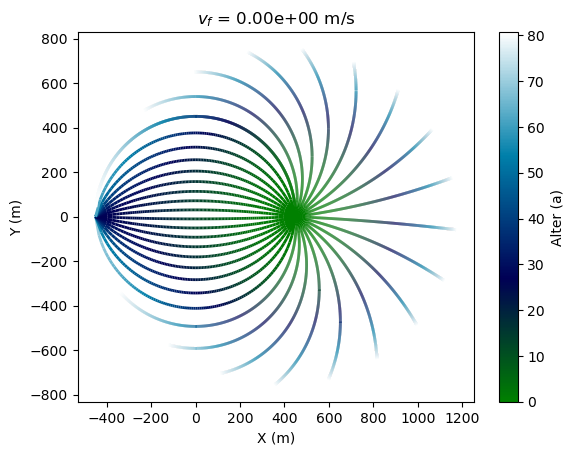

In [6]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from cgplot import plot_with_color_gradient, finalize_plot
from numba import jit, njit

# Geschwindigkeitskomponenten berechnen
@jit(nopython=True)
def velocity_field(t, pos):
    x, y = pos
    A = (x + a)**2 + y**2
    B = (x - a)**2 + y**2
    U = v0*np.cos(alpha) + Q/(2*np.pi*M)*((x+a)/A - (x-a)/B)
    V = v0*np.sin(alpha) + Q/(2*np.pi*M)*(y/A - y/B)
    return [-U, -V]

# Ereignis definieren, um die Integration zu stoppen, wenn der Punkt näher als 1m an (-a, 0) kommt
@jit(nopython=True)
def close_to_point(t, pos):
    x, y = pos
    distance = np.sqrt((x + a)**2 + y**2)
    return distance - 0.1

# close_to_point bei Null stoppen
close_to_point.terminal = True
close_to_point.direction = 0

# Numerische Integration mit dem Runge-Kutta-Verfahren der 4. Ordnung
def integration(x_start, y_start, t_span, dt, N=100):
    # Zeitpunkte für die Ausgabe
    t_eval = np.arange(t_span[0], t_span[1], dt)
    
    # Anfangsbedingungen
    initial_conditions = [x_start, y_start]
    
    # Lösung der Differentialgleichung
    solution = solve_ivp(
        velocity_field, 
        t_span, 
        initial_conditions, 
        method='LSODA', 
        #method='RK45',
        t_eval=t_eval, 
        rtol=1e-5,  # Relative Toleranz
        atol=1e-8,  # Absolute Toleranz
        max_step=30*24*3600,  # Maximale Schrittweite
        events=close_to_point,  # Ereignis hinzufügen   
        dense_output=True,
        first_step=0.1        
    )

    if solution.status == 1:
        if solution.t_events[0].size > 0: 
            #print(f"Ereigniszeitpunkt: t = {solution.t_events[0][0]:.3f} Sekunden")
            t = list()
            y = list()

            tmax = solution.t_events[0][0]

            for a in range(N+1):
                tn = a/N * tmax
                t.append(tn)
                y.append(solution.sol(tn))

            t = np.array(t).transpose()
            y = np.array(y).transpose()

        else:
            print("Ein Fehler ist aufgetreten?!?")
            t = solution.t
            y = solution.y            

    else:
        t = solution.t
        y = solution.y

    return np.array(t), np.array(y), solution


# Startpunkt und Parameter
beta = 0 #np.pi/2
delta = 1


x_start, y_start = a + delta*np.sin(beta), 0.0 + delta*np.cos(beta)
#print(f"{[x_start, y_start]}")
t_span = (0, tmax*a2s)  # Start- und Endzeitpunkt
dt = 0.05 * a2s

doplot = True

if doplot:
    plt.figure()
    plt.title(f"$v_f$ = {v0:.2e} m/s")

I = list()

betas = np.linspace(0, 2*np.pi, 36)

def calc_streamline(beta, doplot=doplot):
    x_start, y_start = a + delta*np.sin(beta), 0.0 + delta*np.cos(beta)
    t, trajectory, solution = integration(x_start, y_start, t_span, dt)

    if doplot:
        plot_with_color_gradient(trajectory[0][:], trajectory[1][:], t/a2s, zmin=0, zmax=tmax, cmap='ocean', linewidth=2)

    return t[-1]/a2s

for beta in betas:
    tau = calc_streamline(beta)
    I.append(tau)

if doplot:

    finalize_plot()

C:\Users\Tecklenburg.J\AppData\Local\Temp\ipykernel_23128\445108388.py:28: RuntimeWarning: invalid value encountered in divide
  tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / a2s


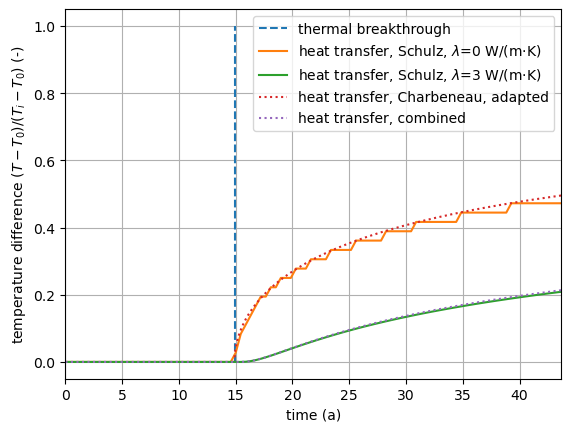

In [ ]:
from scipy.special import erfc

time = np.linspace(0, tmax*G-1, 100) #Die Berechnung ist nur für den Zeitraum tmax*G-1 gültig. Für einen größeren Zeitraum Parameter tmax ändern.
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")

for lambda_ in [1e-8, lambda_S]:

    H = np.sqrt(lambda_*rho_S*c_S) / (M * rho_F * c_F)
    T = np.zeros_like(time)

    for tau in I:

        U = np.heaviside(time-G*tau, 1)
        ind = U > 0
        abc = erfc(H*tau*np.sqrt(a2s)/np.sqrt(time[ind]-G*tau))

        T[ind] = T[ind] + U[ind]*abc

    plt.plot(time, T/len(I), label=f"heat transfer, Schulz, $\lambda$={lambda_:.0f} W/(m$\cdot$K)")


# Formel aus R.J. Charbeneau: Groundwater Hydraulics and Pollutant Transport, 2000
# S. 318 - Formel 6.4.11 -> Adapated for heat transfer

phi1 = np.linspace(0, np.pi, 360)
F = 1 - phi1/np.pi
tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / a2s
tau2 = G*tf/phi

plt.plot(tau2, F, ':', label="heat transfer, Charbeneau, adapted")

# Adapted solution for heat transfer combined with the Schulz's solution
# Note: regional groundwater flow velocity needs to be neglectable compared to well induced flow velocity.
T = np.zeros_like(time)
for tau in tau2:

    U = np.heaviside(time-tau, 1)
    ind = U > 0
    abc = erfc(H*tau/G*np.sqrt(a2s)/np.sqrt(time[ind]-tau))

    T[ind] = T[ind] + U[ind]*abc


plt.plot(time, T/len(tau2), ':', label="heat transfer, combined")

plt.grid()
plt.xlim((0, tmax*G-1))
plt.xlabel("time (a)")
plt.ylabel("temperature difference $(T - T_0) / (T_i - T_0)$ (-)")
plt.legend()
plt.show()